In [65]:
from os import listdir
from os.path import isfile, join
from pipe import *
import json
from pathlib import Path
import numpy as np

import spacy
nlp = spacy.load('en_core_web_lg')

def GetFileStream(path='../worldnews-20170904'):
    files = listdir(path)
    for file in files:
        yield join(path, file)
  
@Pipe
def AdornFile(stream):
    for file in stream:
        yield (file, json.loads(Path(file).read_text(encoding='utf-8')))
        
@Pipe
def As_Npy(l):
    return np.array(list(l))

In [129]:
GetFileStream() \
  | AdornFile() \
  | take(3) \
  | as_list()


[('../worldnews-20170904\\news_0000001.json',
  {'organizations': [],
   'uuid': '767c7dc963d0263187da888fbfd19cd60b0bc2e8',
   'thread': {'social': {'gplus': {'shares': 0},
     'pinterest': {'shares': 0},
     'vk': {'shares': 0},
     'linkedin': {'shares': 0},
     'facebook': {'likes': 0, 'shares': 0, 'comments': 0},
     'stumbledupon': {'shares': 0}},
    'site_full': 'timesofindia.indiatimes.com',
    'main_image': 'http://timesofindia.indiatimes.com/photo/47529300.cms',
    'site_section': 'http://timesofindia.indiatimes.com/rssfeeds/1898184.cms',
    'section_title': 'China News, News in China, Latest News, Daily News | World News - Times of India',
    'url': 'http://timesofindia.indiatimes.com/world/china/China-plans-to-remove-poverty-by-2020/articleshow/49328137.cms',
    'country': 'IL',
    'title': 'China plans to remove poverty by 2020',
    'performance_score': 0,
    'site': 'indiatimes.com',
    'participants_count': 1,
    'title_full': 'China plans to remove pover

In [173]:
X = GetFileStream() \
  | AdornFile() \
  | take(4000) \
  | select( lambda j: j[1]['text'] ) \
  | select( lambda t: nlp(t).vector ) \
  | select( lambda v: v/np.linalg.norm(v) ) \
  | As_Npy()



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [174]:
def GetDocumentTextByIndex(index):
    return GetFileStream() \
      | skip(index) \
      | take(1) \
      | AdornFile() \
      | select( lambda j: j[1]['text'] ) \
      | as_list()
    
def GetDocumentTitleByIndex(index):
    return GetFileStream() \
      | skip(index) \
      | take(1) \
      | AdornFile() \
      | select( lambda j: j[1]['title'] ) \
      | as_list()
      

In [175]:
GetFileStream() | take(5) | as_list()

['../worldnews-20170904\\news_0000001.json',
 '../worldnews-20170904\\news_0000002.json',
 '../worldnews-20170904\\news_0000003.json',
 '../worldnews-20170904\\news_0000004.json',
 '../worldnews-20170904\\news_0000005.json']

In [183]:
X = np.nan_to_num(X)

In [184]:
simmatrix = np.dot(X,X.transpose())

In [178]:
np.min(simmatrix)

-0.22600418

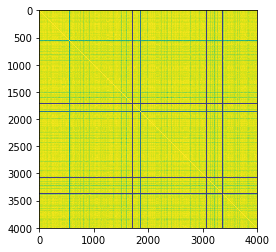

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(simmatrix)
    



In [181]:
# these docs are VERY similar (hypothesis)
list( np.argwhere(np.logical_and( simmatrix >0, simmatrix < 0.1 ))) \
| take( 15 ) \
| select(lambda x: ( GetDocumentTitleByIndex(x[0]),GetDocumentTitleByIndex(x[1]) ) ) \
| as_list()



[(["Target advert shows girl with disabilities as Frozen's Elsa"],
  ['Preserving tradition with House of Mouneh | Life , Lubnan']),
 (["Target advert shows girl with disabilities as Frozen's Elsa"],
  ['Olympiakos bask in glory after first win on English soil | Sports , Football']),
 (["Target advert shows girl with disabilities as Frozen's Elsa"],
  ['Hariri to restore brother’s policy of communicating with people | News , Lebanon News']),
 (["Target advert shows girl with disabilities as Frozen's Elsa"],
  ['Photo Essay: Slonim Rebbe On Motzei Shabbos In Boro Park (Photos By JDN)']),
 (["Target advert shows girl with disabilities as Frozen's Elsa"],
  ['1948 Palestinian paraglides to Syria, allegedly to join rebels | News , Middle East']),
 (["Target advert shows girl with disabilities as Frozen's Elsa"],
  ['A self-portrait in Hitler’s bathtub | Arts & Ent , Culture']),
 (["Target advert shows girl with disabilities as Frozen's Elsa"],
  ['City top after stalemate, Klopp denied fir

In [160]:
list( np.argwhere(np.logical_and( simmatrix >0, simmatrix < 0.5 ))) \
| take( 20 ) \
| as_list()

[array([53, 70], dtype=int64),
 array([70, 53], dtype=int64),
 array([70, 72], dtype=int64),
 array([ 70, 275], dtype=int64),
 array([72, 70], dtype=int64),
 array([154, 221], dtype=int64),
 array([154, 250], dtype=int64),
 array([221, 154], dtype=int64),
 array([221, 275], dtype=int64),
 array([250, 154], dtype=int64),
 array([275,  70], dtype=int64),
 array([275, 221], dtype=int64)]

In [137]:
( , GetDocumentTitleByIndex(70) )

(["Joseph's Tomb set ablaze by Palestinian rioters"],
 ['South Korean orphans separated in 1970s reunited by chance in US | News , World'])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

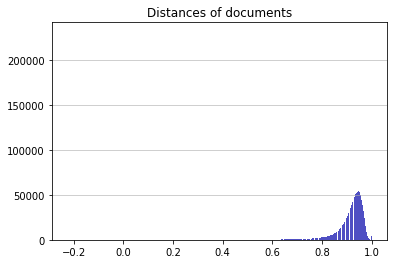

In [186]:
import matplotlib.pyplot as plt

flat_vals = simmatrix[np.triu_indices(4000)]

n, bins, patches = plt.hist(x=flat_vals, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('')
plt.ylabel('')
plt.title('Distances of documents')
maxfreq = n.max()

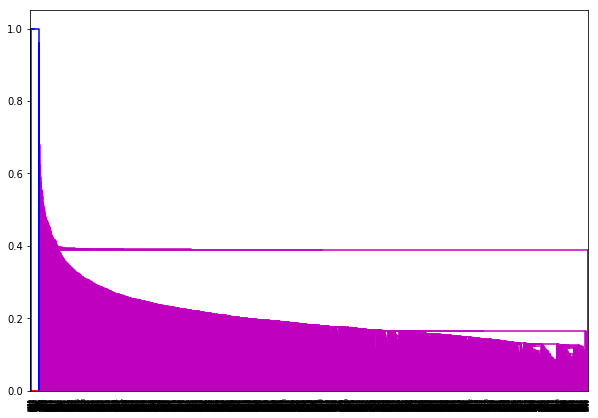

In [187]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

plt.figure(figsize=(10, 7))  
dendrogram(linked,  
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [89]:
linked.shape

(299, 4)

array([-3.77227478e-02,  8.11562538e-02, -1.70762509e-01,  1.60427511e-01,
        9.89169925e-02, -2.14783236e-01, -1.25882506e-01,  3.70697491e-02,
        2.44682491e-01,  2.01197505e+00, -4.57768500e-01,  8.36749971e-02,
        1.40571490e-01,  7.50724971e-02, -3.56707536e-02, -6.51385039e-02,
       -9.27460045e-02,  1.59715009e+00, -1.91312239e-01, -4.32837531e-02,
        1.79207504e-01,  4.39422503e-02, -1.74300000e-01,  1.73272997e-01,
        3.98119241e-02,  3.38304996e-01,  7.80711472e-02, -1.69581503e-01,
        1.05782196e-01,  6.46627545e-02,  1.01412274e-01, -8.11507255e-02,
        3.85800749e-01,  2.03077734e-01,  1.38302997e-01, -1.96362510e-01,
        1.96043998e-01,  1.25200003e-02, -3.66344988e-01, -9.84762460e-02,
        1.27057001e-01, -1.79678500e-01,  9.10974964e-02, -2.24589497e-01,
        1.03493251e-01, -1.01052150e-01,  2.22143501e-01,  1.35983258e-01,
        1.81718737e-01,  1.47866830e-01, -2.33085990e-01,  1.49609745e-01,
        4.95587476e-02, -